# Metaflow - nested foreach
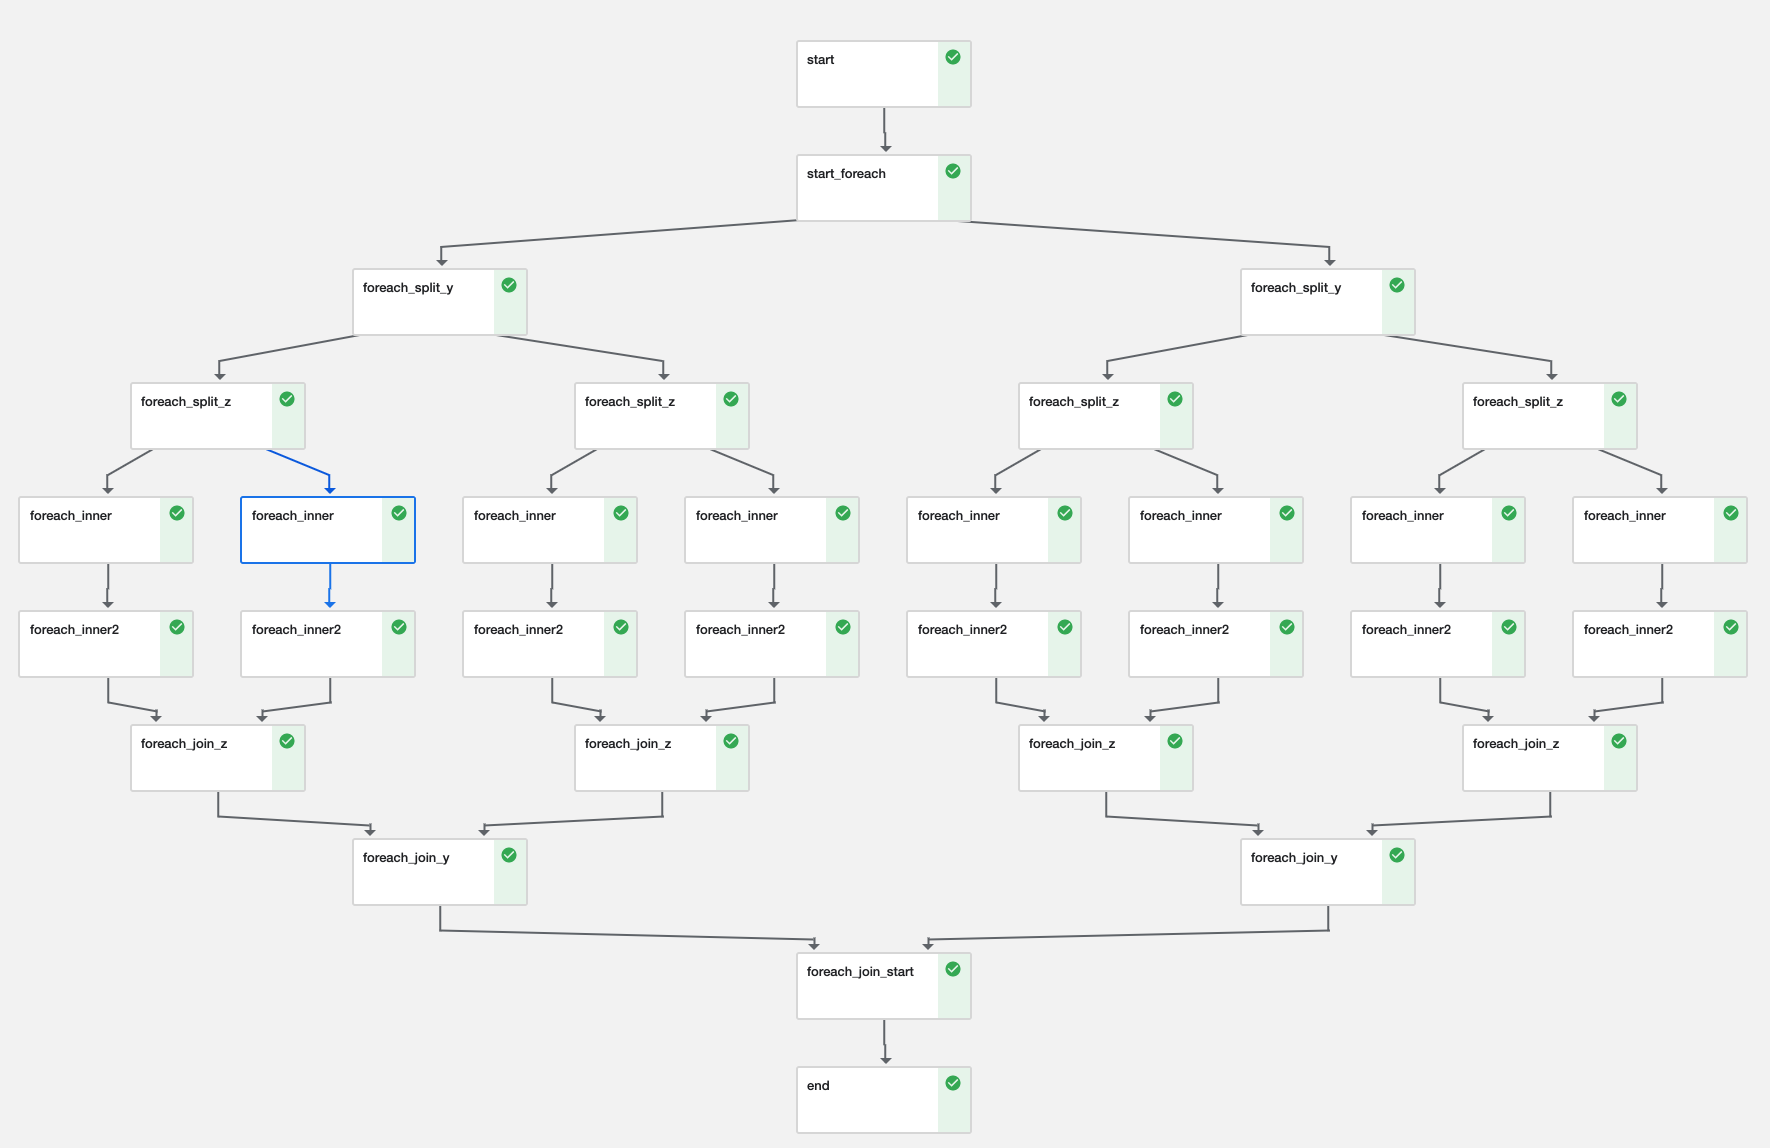

In [ ]:
!pip install -e 'git+https://github.com/zillow/metaflow.git@feature/kfp#egg=metaflow'

In [3]:
!mkdir ~/.metaflowconfig/

In [10]:
%%writefile ~/.metaflowconfig/config.json 
{
        "KFP_RUN_URL_PREFIX": "https://kubeflow.corp.stage-k8s.zg-aip.net/",
        "KFP_SDK_NAMESPACE": "aip-example-stage",
        "METAFLOW_DATASTORE_SYSROOT_S3": "s3://aip-example-stage/metaflow",
        "METAFLOW_DEFAULT_DATASTORE": "local",
        "METAFLOW_USER": "talebz@zillowgroup.com"
}


Overwriting /home/zservice/.metaflowconfig/config.json


In [11]:
%%writefile nested_foreach.py

# -*- coding: utf-8 -*-
from metaflow import FlowSpec, step, Parameter, JSONType
import pprint


def truncate(var):
    var = str(var)
    if len(var) > 500:
        var = '%s...' % var[:500]
    return var



class ExpectationFailed(Exception):

    def __init__(self, expected, got):
        super(ExpectationFailed, self).__init__("Expected result: %s, got %s"\
                                                % (truncate(expected),
                                                   truncate(got)))

def assert_equals(expected, got):
    if expected != got:
        raise ExpectationFailed(expected, got)


class NestedForeachTestFlow(FlowSpec):
    @step
    def start(self):
        self.my_var = 'ab'
        self.x = 'ab'
        self.next(self.start_foreach)
    @step
    def start_foreach(self):
        pprint.pprint(self.my_var)
        self.next(self.foreach_split_y, foreach="x")
    @step
    def foreach_split_y(self):
        self.y = 'cd'
        self.next(self.foreach_split_z, foreach="y")
    @step
    def foreach_split_z(self):
        self.z = 'ef'
        self.next(self.foreach_inner, foreach="z")
    @step
    def foreach_inner(self):
        pprint.pprint(self.input)
        [x, y, z] = self.foreach_stack()
        
        # assert that lengths are correct
        assert_equals(len(self.x), x[1])
        assert_equals(len(self.y), y[1])
        assert_equals(len(self.z), z[1])
        
        # assert that variables are correct given their indices
        assert_equals(x[2], self.x[x[0]])
        assert_equals(y[2], self.y[y[0]])
        assert_equals(z[2], self.z[z[0]])
        
        self.combo = x[2] + y[2] + z[2]
        self.next(self.foreach_inner2)

    @step
    def foreach_inner2(self):
        pprint.pprint(self.my_var)
        self.next(self.foreach_join_z)

    @step
    def foreach_join_z(self, inputs):
        self.merge_artifacts(inputs, exclude="combo")
        pprint.pprint(self.my_var)
        pprint.pprint([(input.x, input.y, input.z) for input in inputs])
        self.next(self.foreach_join_y)
    @step
    def foreach_join_y(self, inputs):
        self.merge_artifacts(inputs) #, exclude="combo")
        pprint.pprint([x for x in inputs])
        self.next(self.foreach_join_start)
    @step
    def foreach_join_start(self, inputs):
        self.merge_artifacts(inputs) #, exclude="combo")
        pprint.pprint([x for x in inputs])
        self.next(self.end)
    @step
    def end(self):
        pprint.pprint(self.my_var)
        pprint.pprint(self.y)
        pprint.pprint(self.z)
        pass
if __name__ == '__main__':
    NestedForeachTestFlow()


Overwriting nested_foreach.py


In [12]:
!python nested_foreach.py --datastore=s3 kfp run

Metaflow 2.0.5.post216+gitb7a9364 executing NestedForeachTestFlow for user:talebz@zillowgroup.com
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Uploaded package to: s3://aip-example-stage/metaflow/NestedForeachTestFlow/data/1a/1a209a366f3070218cde4714759b7c3855c9f0ce
Deploying NestedForeachTestFlow to Kubeflow Pipelines...

Run created successfully!

Metaflow run_id=kfp-f9faf296-981f-42cd-8219-5fc59b99e5e8 

Run link: https://kubeflow.corp.dev.zg-aip.net/_/pipeline/#/runs/details/f9faf296-981f-42cd-8219-5fc59b99e5e8



## step_kfp_output paths and contents
Notice how that the `passed_in_split_indexes` become the taskIds if the Metaflow node `is_inside_foreach`

```python
  f"s3://{flow_root}/step_kfp_outputs/{task_id}.{node.name}.json"
```

In [20]:
!aws s3 ls s3://aip-example-stage/metaflow/NestedForeachTestFlow/kfp-f9faf296-981f-42cd-8219-5fc59b99e5e8/foreach_splits/

2020-11-12 20:27:53         30 2.start_foreach.json
2020-11-12 20:28:05         34 3.0.foreach_split_y.json
2020-11-12 20:28:05         34 3.1.foreach_split_y.json
2020-11-12 20:28:18         38 4.0_0.foreach_split_z.json
2020-11-12 20:28:18         38 4.0_1.foreach_split_z.json
2020-11-12 20:28:18         38 4.1_0.foreach_split_z.json
2020-11-12 20:28:19         38 4.1_1.foreach_split_z.json


### start_foreach

In [23]:
!aws s3 cp s3://aip-example-stage/metaflow/NestedForeachTestFlow/kfp-f9faf296-981f-42cd-8219-5fc59b99e5e8/foreach_splits/2.start_foreach.json -

{"foreach_splits": ["0", "1"]}

### foreach_split_y

In [24]:
!aws s3 cp s3://aip-example-stage/metaflow/NestedForeachTestFlow/kfp-f9faf296-981f-42cd-8219-5fc59b99e5e8/foreach_splits/3.0.foreach_split_y.json -

{"foreach_splits": ["0_0", "0_1"]}

In [25]:
!aws s3 cp s3://aip-example-stage/metaflow/NestedForeachTestFlow/kfp-f9faf296-981f-42cd-8219-5fc59b99e5e8/foreach_splits/3.1.foreach_split_y.json -

{"foreach_splits": ["1_0", "1_1"]}

### foreach_split_z (just two of them)

In [27]:
!aws s3 cp s3://aip-example-stage/metaflow/NestedForeachTestFlow/kfp-f9faf296-981f-42cd-8219-5fc59b99e5e8/foreach_splits/4.0_0.foreach_split_z.json -

{"foreach_splits": ["0_0_0", "0_0_1"]}

In [28]:
!aws s3 cp s3://aip-example-stage/metaflow/NestedForeachTestFlow/kfp-f9faf296-981f-42cd-8219-5fc59b99e5e8/foreach_splits/4.1_0.foreach_split_z.json -

{"foreach_splits": ["1_0_0", "1_0_1"]}